In [70]:
import numpy as np
import pandas as pd
import random
import glob
import math
import xgboost
from sklearn import preprocessing

from matplotlib import pyplot


In [71]:
# Get list of files for the Geo grouped data
# Data sourced from https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-geography-and-service
data_files_list = glob.glob('data/MUP*Geo.csv')
data_files_list 

# For training use 2013 to 2016 to predict 2017
# For testing use 2014 to 2017 to predict 2018
# for validation use 2015 to 2018 to predict 2019

# For presentation use 2016 to 2019 to predict 2020 (and compare against 2019)

['data/MUP_PHY_R19_P04_V10_D17_Geo.csv',
 'data/MUP_PHY_R20_P04_V10_D18_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D13_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D15_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D16_Geo.csv',
 'data/MUP_PHY_R21_P04_V10_D19_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D14_Geo.csv']

In [72]:
df_geo_full = []
for _file in data_files_list:
    df_geo = pd.read_csv(
         _file,
         header=0, 
         #skiprows=lambda i: i>0 and random.random() > p
    )
    year= _file[-10:-8]
    df_geo['year'] = 2000+int(year)
    if len(df_geo_full)!=0:
        df_geo_full = df_geo_full.append(df_geo, ignore_index=False)
    else:
        df_geo_full = df_geo.copy()

df_geo_full= df_geo_full.loc[df_geo_full['year']!= 0,:]

excl_states =  ['Armed Forces Central/South America', 'Armed Forces Europe', 'Armed Forces Pacific', 'Foreign Country','National']
df_geo_full = df_geo_full.loc[~df_geo_full['Rndrng_Prvdr_Geo_Desc'].isin(excl_states),:].copy()

/tmp/ipykernel_19469/1583512775.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_geo = pd.read_csv(
/tmp/ipykernel_19469/1583512775.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_geo = pd.read_csv(
/tmp/ipykernel_19469/1583512775.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_geo_full = df_geo_full.append(df_geo, ignore_index=False)
/tmp/ipykernel_19469/1583512775.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_geo = pd.read_csv(
/tmp/ipykernel_19469/1583512775.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_geo_full = df_geo_full.append(df_geo, ignore_index=False)
/tmp/ipykernel_19469/1583512775.py:3: DtypeW

In [73]:
# Prep geo_full for train/test/val

df_geo_features = df_geo_full.loc[:,['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd', 'Tot_Srvcs','year']].copy()
df_geo_features = df_geo_features.groupby(['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd','year'])[ 'Tot_Srvcs'].sum().reset_index()
df_geo_features.loc[:,'Tot_Srvcs'] = df_geo_features['Tot_Srvcs'].apply(lambda x: math.log(x))

df_geo_features.loc[:,'idx'] = df_geo_features.apply(lambda x:  "_".join([str(x['Rndrng_Prvdr_Geo_Desc']), str(x['HCPCS_Cd'])]), axis=1)
start_year = 2013
no_of_years = 4
df_geo_features.loc[:,'year'] = start_year + no_of_years - df_geo_features['year'] 
df_geo_features_train = df_geo_features.loc[df_geo_features['year']>=0,:].copy()
df_geo_features_train = df_geo_features_train.loc[df_geo_features_train['year'] <= no_of_years,:]

df_geo_features_test = df_geo_features.loc[df_geo_features['year']>=-1,:].copy()
df_geo_features_test.loc[:,'year'] = df_geo_features_test['year'] + 1
df_geo_features_test = df_geo_features_test.loc[df_geo_features_test['year']<=no_of_years,:].copy()

df_geo_features_train = df_geo_features_train.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')
df_geo_features_test = df_geo_features_test.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')

col_map = {
    0: "target",
    1: "1",
    2: "2",
    3: "3"
}

df_geo_features_train.rename(columns = col_map, inplace=True)
df_geo_features_test.rename(columns = col_map, inplace=True)

df_geo_features_train['state'] = df_geo_features_train.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values
df_geo_features_test['state'] = df_geo_features_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

df_geo_features_train.reset_index(inplace=True)
df_geo_features_test.reset_index(inplace=True)

df_geo_features_train.fillna(0, inplace=True)
df_geo_features_test.fillna(0, inplace=True)

In [74]:
df_geo_features_test.sample(5)

year,idx,target,1,2,3,4,state
150984,New York_33463,4.564348,3.891820,4.465908,4.127134,4.127134,New York
214365,Utah_33235,3.931826,3.555348,3.496508,3.496508,2.944439,Utah
240699,Wyoming_63709,0.000000,0.000000,0.000000,0.000000,2.564949,Wyoming
125952,Montana_29819,0.000000,0.000000,2.833213,2.484907,0.000000,Montana
123014,Missouri_72020,8.843038,8.824089,8.792398,8.764834,8.856946,Missouri


In [75]:
df_geo_features_train.sample(5)

year,idx,target,1,2,3,4,state
207088,Texas_33418,5.726848,5.308268,4.804021,0.000000,0.000000,Texas
105083,Michigan_19281,7.169350,7.185387,7.202661,7.216709,0.000000,Michigan
6226,Alaska_70491,6.150603,6.186209,6.232448,5.866468,5.783825,Alaska
216388,Vermont_10030,0.000000,2.484907,2.833213,3.178054,0.000000,Vermont
109104,Michigan_87177,6.842683,7.003065,6.993933,7.295735,7.484930,Michigan


In [76]:
# Import population estimates data
pop_est = pd.read_csv("data/SC-EST2020-ALLDATA5.csv")

# Drop columns that is not needed for "one row" melting
pop_est.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE'], axis='columns', inplace=True)

In [77]:
pop_est.sample(3)

,NAME,SEX,ORIGIN,RACE,AGE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
1990,Alabama,1,1,4,12,534,534,523,530,580,580,594,636,671,607,658,631,667
161784,South Dakota,2,1,2,18,135,135,136,134,155,156,159,174,178,194,178,190,215
133931,North Dakota,1,2,3,29,17,17,18,13,5,21,42,33,27,18,26,42,40


In [78]:
pop_est['age_category'] =  pop_est['AGE'].apply(lambda x: 1 if x >40  else 0) 
#pop_est['idx'] = pop_est.apply(lambda x:  "_".join([str(x['SEX']), str(x['ORIGIN']), str(x['RACE']), str(x['AGE'])]), axis=1)
pop_est.drop(['SEX', 'ORIGIN', 'RACE', 'AGE'], axis='columns', inplace=True)

In [79]:
pop_agg_df = pop_est.copy()
pop_agg_df.drop(['CENSUS2010POP','ESTIMATESBASE2010'], axis = 'columns', inplace=True)

pop_agg_df = pd.melt(pop_agg_df,id_vars=['NAME','age_category'])

pop_agg_df.loc[:,'year'] = pop_agg_df['variable'].apply(lambda x: int(x[-4:]))
#popestimate df
pop_agg_df.drop(['variable'], axis='columns', inplace=True)

pop_agg_df = pop_agg_df.groupby(['NAME','age_category','year']).sum().reset_index()
# set t=0 for base year

# set year count to integers from 0 to x for train and test split
start_year = 2013
no_of_years = 4
pop_agg_df.loc[:,'year'] = start_year + no_of_years - pop_agg_df['year'] 
pop_train_df = pop_agg_df.loc[pop_agg_df['year']>0,:].copy()
pop_train_df = pop_train_df.loc[pop_train_df['year'] <= no_of_years,:]
pop_test_df = pop_agg_df.loc[pop_agg_df['year']>-1,:].copy()
pop_test_df.loc[:,'year'] = pop_test_df['year'] + 1
pop_test_df = pop_test_df.loc[pop_test_df['year'] <= no_of_years,:]

pop_train_df.loc[:,'idx'] = pop_train_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_train_df = pop_train_df.pivot(index='NAME', columns=['idx'], values='value')

pop_test_df.loc[:,'idx'] = pop_test_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_test_df = pop_test_df.pivot(index='NAME', columns=['idx'], values='value')

# normalise values based on train data only

_mean = pop_train_df.stack().mean()
_std = pop_train_df.stack().std()

pop_train_df = (pop_train_df-_mean)/_std
pop_test_df = (pop_test_df-_mean)/_std

pop_train_df.index.name = 'state'
pop_test_df.index.name = 'state'

pop_train_df.reset_index(inplace=True)
pop_test_df.reset_index(inplace=True)

In [80]:
pop_train_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
46,Virginia,0.410374,0.404800,0.398453,0.391431,0.197277,0.186812,0.176805,0.165156
50,Wyoming,-0.781783,-0.781225,-0.781926,-0.782201,-0.798755,-0.799054,-0.799364,-0.799324
15,Iowa,-0.403392,-0.405209,-0.408003,-0.411965,-0.474962,-0.476538,-0.477528,-0.478731


In [81]:
pop_test_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
40,South Carolina,-0.143067,-0.150215,-0.157097,-0.165300,-0.211951,-0.223221,-0.235576,-0.247250
3,Arkansas,-0.422374,-0.423939,-0.425101,-0.426399,-0.489533,-0.491847,-0.494542,-0.496743
6,Connecticut,-0.366636,-0.366110,-0.364265,-0.362967,-0.383384,-0.383339,-0.383399,-0.383345


In [82]:
full_train = df_geo_features_train.merge(pop_train_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')
full_test = df_geo_features_test.merge(pop_test_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')

In [83]:
full_test.sample(5)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
idx,,,,,,,,,,,,,
Mississippi_86644,2.708050,0.000000,0.000000,0.000000,0.000000,-0.421682,-0.420003,-0.418299,-0.416519,-0.500592,-0.502625,-0.504733,-0.506360
Missouri_46060,2.708050,3.135494,2.708050,2.639057,3.433987,0.036166,0.032899,0.031488,0.028760,-0.084719,-0.088102,-0.092177,-0.095076
Kansas_73220,5.147494,5.093750,4.962845,4.962845,4.700480,-0.413324,-0.412155,-0.411754,-0.413781,-0.516354,-0.517500,-0.518983,-0.519892
Florida_29899,2.564949,2.708050,0.000000,0.000000,2.944439,1.995818,1.953507,1.903172,1.856782,2.066368,2.009058,1.943417,1.885768
South Dakota_37248,2.944439,3.218876,0.000000,0.000000,0.000000,-0.736274,-0.738188,-0.739969,-0.740969,-0.763757,-0.764751,-0.765655,-0.766213


In [84]:
best_params = {'colsample_bytree': 0.9682038820754064,
 'gamma': 1.0184993645158578,
 'max_depth': int(12.0),
 'min_child_weight': int(8.0),
 'n_estimators': int(6),
 'reg_alpha': 113.0,
 'reg_lambda': 0.08792023426025397}

model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=1.0184993645158578,                 
                 learning_rate=0.007,
                 max_depth=12,
                 min_child_weight=8,
                 n_estimators=100000,                                                                    
                 reg_alpha=0,
                 reg_lambda=0,
                 subsample=0.8,
                 seed=117,
                            ) 


In [85]:
x_train = full_train.drop(["target"], axis=1)
y_train = full_train['target']
x_test = full_test.drop(["target"], axis=1)
y_test= full_test['target']

In [86]:
model.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test,y_test)], early_stopping_rounds=50,verbose=False)

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=1.0184993645158578, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.007, max_delta_step=0,
             max_depth=12, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=6000, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=117,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=117,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

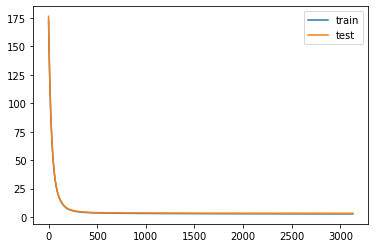

In [87]:
results = model.evals_result()
# plot learning curves
_train_results = np.array(list(map(math.exp,results['validation_0']['rmse'])))
_test_results = np.array(list(map(math.exp,results['validation_1']['rmse'])))
pyplot.plot(_train_results, label='train')
pyplot.plot(_test_results, label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [88]:
y_pred = model.predict(x_test)

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [89]:
full_test['state'] = full_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

In [90]:
def perc_round(x):
    return round(x,-2)

full_test['pred'] = np.array(list(map(math.exp,y_pred)))
full_test['target_original'] = np.array(list(map(math.exp,full_test['target'])))
full_test['total_diff'] = np.array(list(map(round, full_test['target_original'] - full_test['pred'])))
full_test['perc_diff'] = full_test['total_diff'].values/full_test['target_original'].values

In [94]:
full_test.sample(15)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff
idx,,,,,,,,,,,,,,,,,,
New Hampshire_26735,2.944439,2.772589,0.000000,0.000000,2.772589,-0.690915,-0.691884,-0.692595,-0.692834,-0.679465,-0.680501,-0.681691,-0.682482,New Hampshire,2.500681,19.0,16,0.842105
North Carolina_54100,4.605170,4.736198,4.836282,4.624973,4.744932,0.653459,0.639570,0.624579,0.614615,0.451763,0.432220,0.410943,0.391585,North Carolina,116.383667,100.0,-16,-0.160000
Arizona_01120,4.770685,4.644391,4.663439,4.634729,4.770685,0.207604,0.196971,0.184604,0.173674,0.015564,-0.003810,-0.023994,-0.042012,Arizona,107.212801,118.0,11,0.093220
Montana_87184,3.784190,3.367296,3.871201,4.204693,4.691348,-0.718028,-0.720007,-0.721793,-0.723438,-0.730920,-0.732440,-0.733785,-0.734737,Montana,32.940238,44.0,11,0.250000
Louisiana_96154,0.000000,0.000000,0.000000,0.000000,4.700480,-0.155642,-0.151802,-0.152418,-0.155233,-0.299834,-0.302152,-0.306059,-0.309669,Louisiana,2.212188,1.0,-1,-1.000000
North Carolina_45397,0.000000,2.708050,0.000000,0.000000,0.000000,0.653459,0.639570,0.624579,0.614615,0.451763,0.432220,0.410943,0.391585,North Carolina,5.291191,1.0,-4,-4.000000
Utah_11755,6.056784,5.529429,5.433722,4.127134,4.382027,-0.308681,-0.317305,-0.326718,-0.333199,-0.571175,-0.579650,-0.587673,-0.594245,Utah,293.591395,427.0,133,0.311475
Wyoming_84145,2.484907,0.000000,0.000000,0.000000,0.000000,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364,Wyoming,28.727219,12.0,-17,-1.416667
New York_74280,5.814131,5.937536,6.073045,6.302619,6.555357,2.028074,2.041380,2.052940,2.056700,1.675851,1.671264,1.662135,1.653787,New York,275.355495,335.0,60,0.179104


In [95]:
full_test_sum = full_test.groupby(['state']).mean()
full_test_sum['perc_diff'] = full_test_sum['total_diff'].values/full_test_sum['target_original'].values
full_test_sum

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,pred,target_original,total_diff,perc_diff
state,,,,,,,,,,,,,,,,,
Alabama,4.731577,4.765754,4.876559,4.929091,4.888554,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,11306.919913,12181.742127,874.821886,0.071814
Alaska,4.016383,3.912151,3.786894,3.753294,3.586644,-0.738980,-0.738410,-0.739370,-0.739752,-0.786242,-0.786586,-0.787076,-0.787268,1705.094161,1963.029078,257.913564,0.131386
American Samoa,3.545848,3.651175,3.699190,3.417921,3.271268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.904132,242.777778,44.777778,0.184439
Arizona,5.010179,4.913235,4.866397,4.825870,4.738133,0.207604,0.196971,0.184604,0.173674,0.015564,-0.003810,-0.023994,-0.042012,12017.155077,13864.593295,1847.419738,0.133247
Arkansas,4.516073,4.454019,4.460854,4.527186,4.479630,-0.422374,-0.423939,-0.425101,-0.426399,-0.489533,-0.491847,-0.494542,-0.496743,8015.788633,8524.247319,508.471807,0.059650
California,5.594946,5.534571,5.500199,5.449106,5.417563,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,35549.120051,46666.585341,11117.472415,0.238232
Colorado,4.699988,4.624256,4.576409,4.554724,4.510389,0.018745,0.007310,-0.006639,-0.024039,-0.190727,-0.200887,-0.212898,-0.224931,6809.586915,8112.530875,1302.955865,0.160610
Connecticut,4.324508,4.406576,4.453731,4.625364,4.607304,-0.366636,-0.366110,-0.364265,-0.362967,-0.383384,-0.383339,-0.383399,-0.383345,5279.340660,5869.925350,590.590351,0.100613
Delaware,4.199545,4.174130,4.110285,4.128022,4.057584,-0.733901,-0.734477,-0.734897,-0.735719,-0.741599,-0.743420,-0.745366,-0.747187,2819.947702,3519.645469,699.694118,0.198797


In [24]:
full_test.sort_values('pred',ascending=False)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff
idx,,,,,,,,,,,,,,,,,,
California_Q9967,16.107760,16.059161,16.023511,15.941482,15.959088,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,California,7.873626e+06,9897179.7,2023554,0.204458
California_99213,15.977317,16.004393,16.029845,16.044195,16.066907,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,California,7.873626e+06,8686818.5,813192,0.093612
Texas_Q9967,16.030637,16.039197,16.019768,15.991413,16.019904,3.765884,3.715102,3.650929,3.569424,2.305769,2.248578,2.185494,2.123262,Texas,7.493917e+06,9162566.3,1668649,0.182116
Texas_A0425,16.276326,16.325137,16.295087,16.282559,16.187829,3.765884,3.715102,3.650929,3.569424,2.305769,2.248578,2.185494,2.123262,Texas,7.493917e+06,11714356.3,4220439,0.360279
Florida_Q0138,16.284928,16.119656,16.156415,15.963191,15.935271,1.995818,1.953507,1.903172,1.856782,2.066368,2.009058,1.943417,1.885768,Florida,7.205057e+06,11815556.0,4610499,0.390206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mississippi_J9351,0.000000,0.000000,8.173011,0.000000,8.789965,-0.421682,-0.420003,-0.418299,-0.416519,-0.500592,-0.502625,-0.504733,-0.506360,Mississippi,2.744787e-01,1.0,1,1.000000
Tennessee_83789,4.394449,0.000000,6.898715,12.171911,12.504858,0.118073,0.107946,0.100679,0.094020,-0.006950,-0.015463,-0.024697,-0.032966,Tennessee,2.473220e-01,81.0,81,1.000000
Oklahoma_J9178,0.000000,0.000000,7.495542,0.000000,7.895436,-0.226620,-0.226902,-0.229508,-0.236450,-0.382753,-0.385034,-0.388473,-0.391567,Oklahoma,2.299776e-01,1.0,1,1.000000


In [25]:
del(df_geo)
del(df_geo_features)
del(df_geo_features_test)
del(df_geo_features_train)
del(df_geo_full)
del(pop_agg_df)
del(pop_test_df)
del(pop_train_df)


In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score
num_estimator = [100,150,200,250,500,1000,2000,5000,10000]
import xgboost as xgb

space=  {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 30,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice("n_estimators", num_estimator),
    }

def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']) , min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective="reg:squarederror")
    
    score_cv = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    return {'loss':-score_cv, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print(best)

  0%|                                                                           | 0/200 [00:00<?, ?trial/s, best loss=?]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  0%|▏                                              | 1/200 [00:44<2:25:59, 44.02s/trial, best loss: 0.6135579100582856]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  1%|▍                                             | 2/200 [03:19<6:01:37, 109.59s/trial, best loss: 0.6135579100582856]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  2%|▋                                              | 3/200 [04:20<4:47:22, 87.52s/trial, best loss: 0.6130941326038369]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  2%|▉                                              | 4/200 [05:50<4:49:14, 88.54s/trial, best loss: 0.6130941326038369]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  2%|█▏                                           | 5/200 [13:32<12:05:24, 223.21s/trial, best loss: 0.6121720630223857]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  3%|█▎                                           | 6/200 [17:54<12:43:52, 236.25s/trial, best loss: 0.6121720630223857]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  4%|█▌                                           | 7/200 [34:16<25:43:54, 479.97s/trial, best loss: 0.6121720630223857]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  4%|█▊                                           | 8/200 [55:50<39:26:01, 739.38s/trial, best loss: 0.6121720630223857]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  4%|██                                           | 9/200 [57:04<28:10:37, 531.09s/trial, best loss: 0.6121720630223857]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  5%|██                                       | 10/200 [1:33:09<54:39:31, 1035.64s/trial, best loss: 0.6121720630223857]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  6%|██▎                                       | 11/200 [1:34:34<39:05:29, 744.60s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  6%|██▌                                       | 12/200 [1:35:36<28:02:50, 537.08s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  6%|██▋                                       | 13/200 [1:50:35<33:35:12, 646.59s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  7%|██▉                                       | 14/200 [1:50:49<23:31:59, 455.48s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  8%|███▏                                      | 15/200 [1:51:44<17:12:36, 334.90s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  8%|███▎                                      | 16/200 [2:08:05<27:03:33, 529.42s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  8%|███▌                                      | 17/200 [2:09:11<19:49:26, 389.98s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

  9%|███▊                                      | 18/200 [2:09:44<14:18:02, 282.87s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

 10%|███▉                                      | 19/200 [2:10:51<10:57:36, 217.99s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packa

 10%|████▏                                     | 20/200 [2:17:41<13:46:52, 275.62s/trial, best loss: 0.6099345621028881]

/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



In [30]:
best

{'colsample_bytree': 0.9682038820754064,
 'gamma': 1.0184993645158578,
 'max_depth': 12.0,
 'min_child_weight': 8.0,
 'n_estimators': 6,
 'reg_alpha': 113.0,
 'reg_lambda': 0.08792023426025397}

{'colsample_bytree': 0.9682038820754064,
 'gamma': 1.0184993645158578,
 'max_depth': 12.0,
 'min_child_weight': 8.0,
 'n_estimators': 6,
 'reg_alpha': 113.0,
 'reg_lambda': 0.08792023426025397}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f3594ae2-e1b0-4476-8420-ffda39dfce6e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>